In [1]:
import pandas as pd
# 0.78468


In [2]:
# Fix bug that I had https://www.kaggle.com/c/bosch-production-line-performance/discussion/25082
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [3]:
import matplotlib
%matplotlib inline

In [4]:
path = "/Users/saaryalov/Downloads/"
train = pd.read_csv(path+"train.csv")
test = pd.read_csv(path+"test.csv")

train["Survived"] = train["Survived"].astype(int)
full = pd.concat([train,test],axis=0,ignore_index=True)
sub_example = full[["PassengerId","Survived"]]

/anaconda3/envs/data_science_club/lib/python3.6/site-packages/ipykernel/__main__.py:6: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [5]:
train.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Imputing Missing Values

In [5]:
for col in full.select_dtypes("float64").columns:
    if col != "Survived":
        full[col].loc[full[col].isna()] = train[col].mean()
        
for col in full.select_dtypes("O").columns:     
    full[col].loc[full[col].isna()] = "Missing"

/anaconda3/envs/data_science_club/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


# Feature Engineering


In [6]:
full.head(10)

# Manual Features
full["IsLoner"] = ((full["Age"] >= 18) & (full["SibSp"] == 0) & (full["Parch"]==0))*1
full["IsChild"] = (full["Age"] <= 18)*1
full["IsMarriedMan"] = ((full["Sex"] == "male")&(full["SibSp"]>0))*1
full["IsFamilyGuy"] = ((full["Sex"] == "male")&(full["SibSp"]>0)&(full["Parch"]>0))*1



In [7]:
import re

full["Title"] = full["Name"]

for row in range(0,full.shape[0]):
    full.loc[row,"Title"] = re.sub('(.*, )|(\\..*)',"",full["Name"].loc[row])
    



In [8]:
dist = pd.Series(index=full["Title"].unique())
for each in dist.index:
    dist.loc[each] = sum(full["Title"]==each)

In [9]:
dist

Mr              757.0
Mrs             197.0
Miss            260.0
Master           61.0
Don               1.0
Rev               8.0
Dr                8.0
Mme               1.0
Ms                2.0
Major             2.0
Lady              1.0
Sir               1.0
Mlle              2.0
Col               4.0
Capt              1.0
the Countess      1.0
Jonkheer          1.0
Dona              1.0
dtype: float64

In [10]:
full.Title[(full.Title=="Don") | (full.Title=="Capt") | (full.Title=="Major") | (full.Title=="Col") | (full.Title=="Jonkheer")] = "Mr"
full.Title[(full.Title=="Ms") | (full.Title=="the Countess") | (full.Title=="Lady")] = "Miss"
full.Title[(full.Title=="Mme") | (full.Title=="Mlle") | (full.Title=="Dona")] = "Mrs"
full.Title[(full.Title=="Sir")] = "Mr"

/anaconda3/envs/data_science_club/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/anaconda3/envs/data_science_club/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/anaconda3/envs/data_science_club/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()

In [11]:
dist_2 = pd.Series(index=full["Title"].unique())
for each in dist_2.index:
    dist_2.loc[each] = sum(full["Title"]==each)
dist_2

Mr        767.0
Mrs       201.0
Miss      264.0
Master     61.0
Rev         8.0
Dr          8.0
dtype: float64

In [12]:
# Drop some features
full.drop(["Name","Ticket","Cabin",'PassengerId',"Embarked"],axis=1,inplace=True)


In [13]:
full = pd.get_dummies(full)

In [14]:
train_fe = full[~full.Survived.isna()].loc[0:599]
valid_fe = full[~full.Survived.isna()].loc[600:891]
test_fe = full[full.Survived.isna()]

# Model Fitting

In [15]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
# Create RF Object
clf = XGBClassifier()
# Fit model
fitted = clf.fit(train_fe.drop("Survived",axis=1),train_fe["Survived"])
# Predict
pred = fitted.predict(valid_fe.drop("Survived",axis=1))


/anaconda3/envs/data_science_club/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
/anaconda3/envs/data_science_club/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [16]:
accuracy_score(valid_fe["Survived"],pred)

0.8384879725085911

In [17]:
import shap
shap_values = shap.TreeExplainer(clf).shap_values(train_fe.drop("Survived",axis=1))

In [18]:
shap_values.shape

(600, 17)

In [19]:
import numpy as np
np.mean(np.abs(shap_values),axis=0)

array([0.23228686, 0.31985223, 0.01279481, 0.52998734, 0.16289431,
       0.00939967, 0.        , 0.07772988, 0.        , 1.0290993 ,
       0.        , 0.        , 0.12319941, 0.00474033, 0.20549649,
       0.03383422, 0.        ], dtype=float32)

In [20]:
cols = train_fe.drop("Survived",axis=1).columns

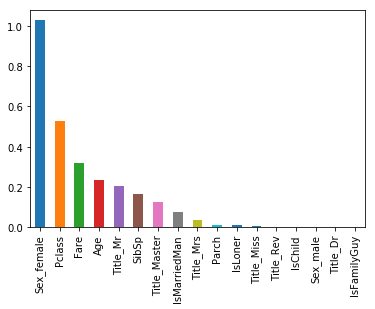

In [21]:
ser = pd.Series(np.mean(np.abs(shap_values),axis=0),index=cols).sort_values(ascending=False)
ser.plot(kind="bar")

In [22]:
# It seems like Title Rev is overfitting
full.columns
full['Title_Mr'] +=  full['Title_Rev']
full['Title_Mr'] += full['Title_Dr']
full.drop(['Title_Rev',"Title_Dr"],axis=1,inplace=True)

In [23]:
#del full["Sex_female"]
train_fe = full[~full.Survived.isna()].loc[0:599]
valid_fe = full[~full.Survived.isna()].loc[600:891]
test_fe = full[full.Survived.isna()]

from sklearn.metrics import accuracy_score
# Create RF Object
clf = XGBClassifier()
# Fit model
fitted = clf.fit(train_fe.drop(["Survived"],axis=1),train_fe["Survived"])
# Predict
pred = fitted.predict(valid_fe.drop(["Survived"],axis=1))
accuracy_score(valid_fe["Survived"],pred)

/anaconda3/envs/data_science_club/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.8419243986254296

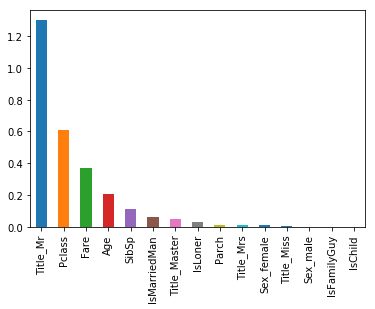

In [24]:
shap_values = shap.TreeExplainer(clf).shap_values(train_fe.drop("Survived",axis=1))
pd.Series(np.mean(np.abs(shap_values),axis=0),index=train_fe.drop("Survived",axis=1).columns).sort_values(ascending=False).plot(kind="bar")

In [25]:
pred = fitted.predict(test_fe.drop("Survived",axis=1))

/anaconda3/envs/data_science_club/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [36]:
sub = sub_example.loc[sub_example.Survived.isna()]  


In [37]:
sub["Survived"] = pred.astype("int")

/anaconda3/envs/data_science_club/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [27]:
#sub.to_csv("titanic_first_sub.csv",index=False)